<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facial Emotion Recognition

Project Configuration

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Dataset
!pip install kaggle
! mkdir ~/.kaggle
! cp {kaggle_json_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
! unzip facial-expression-dataset.zip

# Set File Paths
train_path = '/content/train/train/'
test_path = '/content/test/test/'

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [4]:
# Load Dataset
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [5]:
# Convert training dataset into a dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_path)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

# Convert testing dataset into a dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_path)

# Shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)
test.head()

fear Completed
neutral Completed
disgust Completed
happy Completed
sad Completed
angry Completed
surprise Completed
fear Completed
neutral Completed
disgust Completed
happy Completed
sad Completed
angry Completed
surprise Completed


,image,label
0,/content/test/test/sad/PrivateTest_7451234.jpg,sad
1,/content/test/test/angry/PublicTest_70604594.jpg,angry
2,/content/test/test/happy/PrivateTest_54479403.jpg,happy
3,/content/test/test/happy/PrivateTest_49578545.jpg,happy
4,/content/test/test/happy/PrivateTest_78066989.jpg,happy


Data Analysis

<Axes: xlabel='count', ylabel='label'>

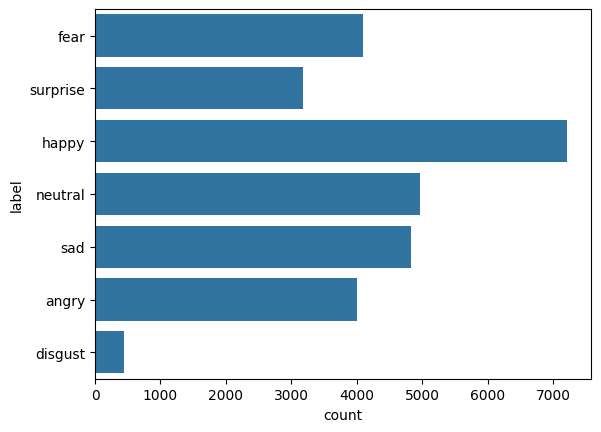

In [6]:
# Plotting Frequency of Labels in training dataset
sns.countplot(train['label'])

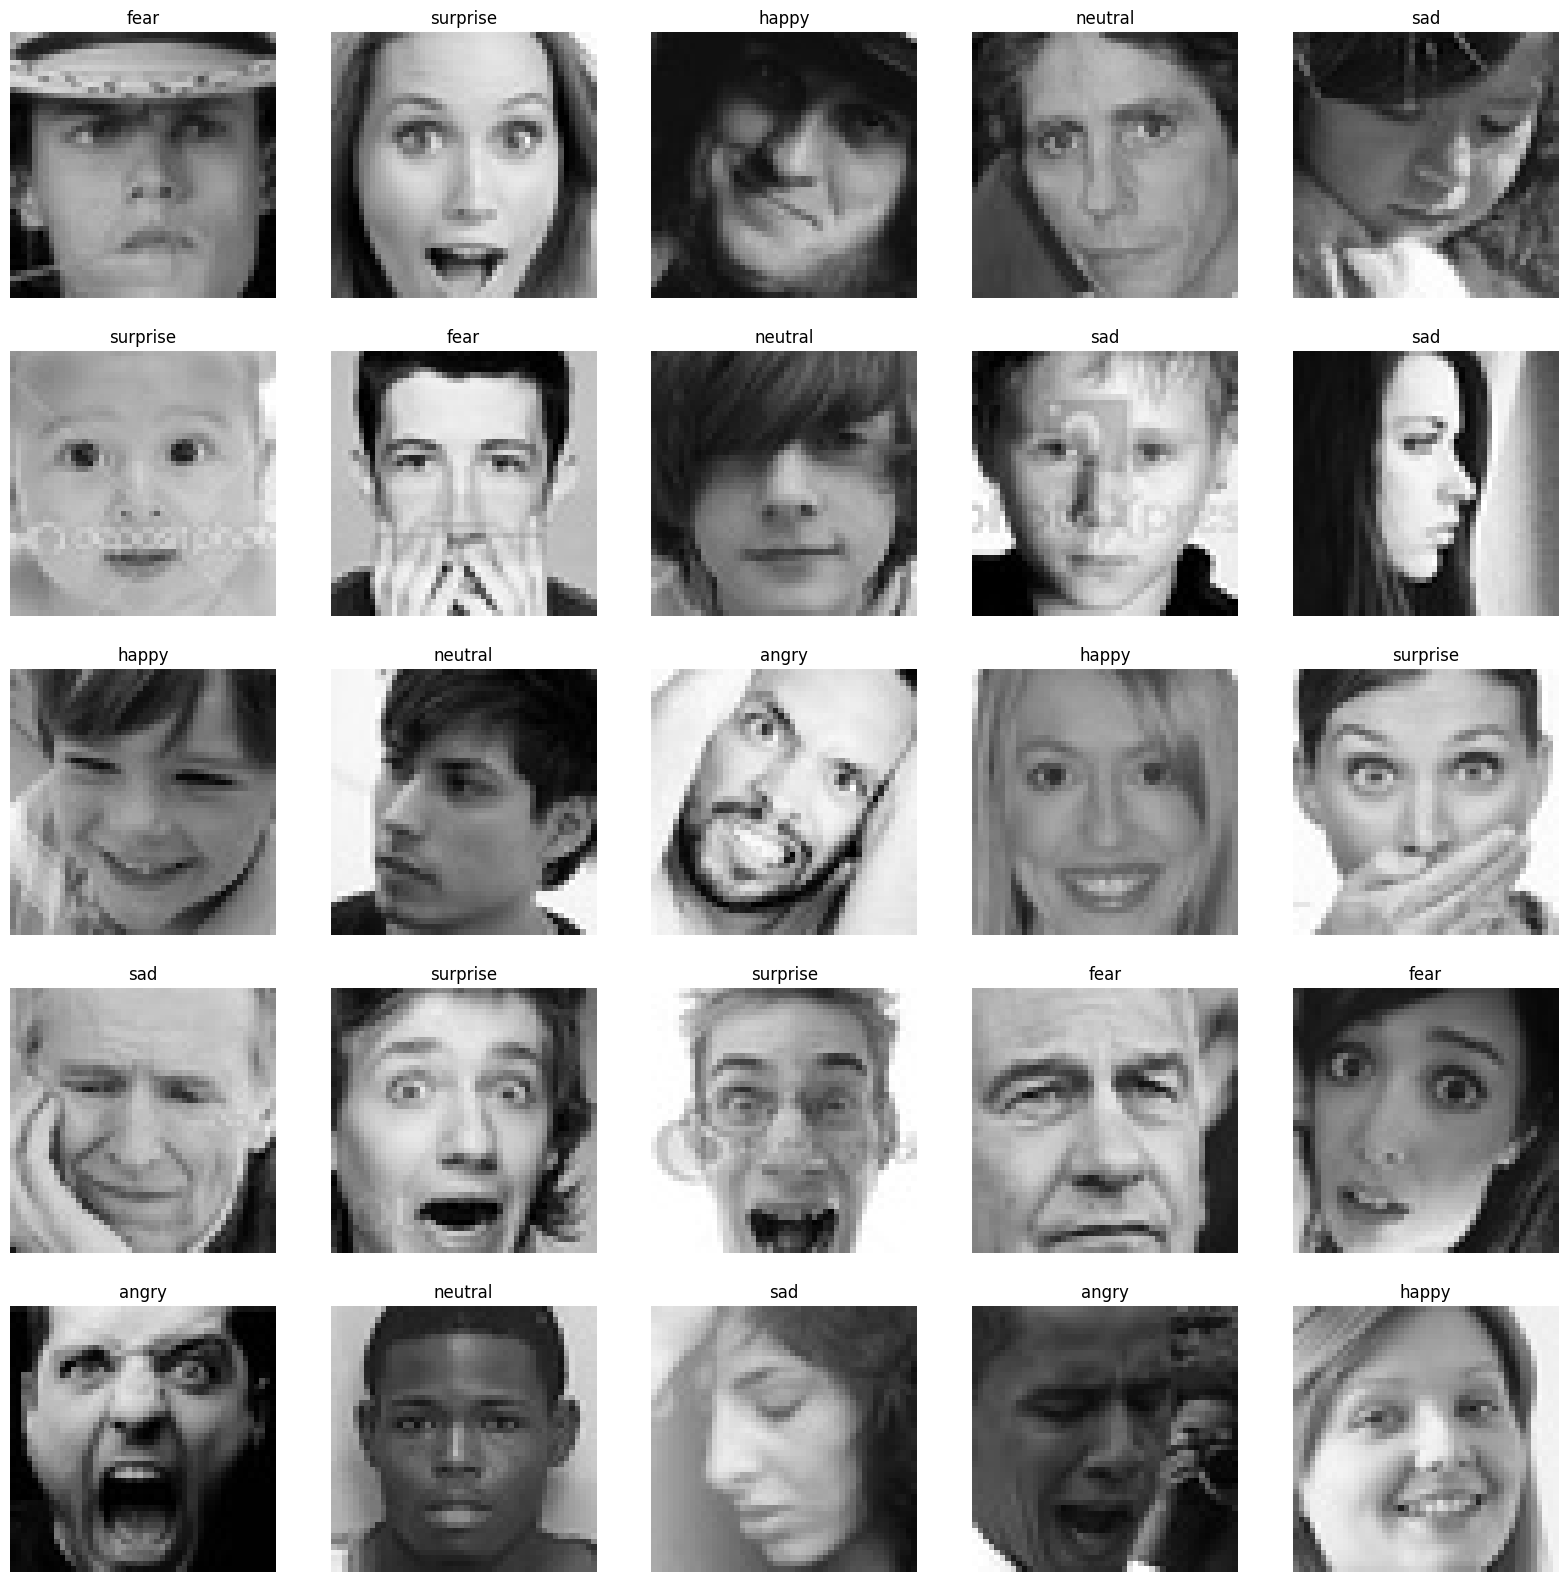

In [7]:
# Sample Images from Training Dataset
from PIL import Image

# img = Image.open(train['image'][0])
# plt.imshow(img, cmap='gray');

plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

Feature Extraction

In [8]:
# Extract features from these images to use as input when training CNN
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [9]:
# Extract features for training dataset
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [10]:
# Extract features for testing dataset
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [11]:
# Normalize the Images to improve convergence of CNN
x_train = train_features/255.0
x_test = test_features/255.0

In [12]:
# Transform Training Labels to Integer Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [13]:
# Convert the Integer Labels into a Binary Vector
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
# Seeing how the vector looks like
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [15]:
# Configuration for Model
input_shape = (48, 48, 1)
output_class = 7

Model Creation

In [16]:
# Defining the Model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten Layers
model.add(Flatten())

# Fully Conntected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output Layer using the softmax activation function
model.add(Dense(output_class, activation='softmax'))

# Compile Model using the Adam optimizer tracking accuracy and loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# Train the Model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
100/225 [============>.................] - ETA: 14:19 - loss: 1.8353 - accuracy: 0.2409